# kriging_est関数とRの結果を比較する
- 推定結果が大きく異なってしまう原因を探る
- cvを行う

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import calc_variogram as variogram
import kriging_est as kriging

In [2]:
%load_ext autoreload
%autoreload 2

In [65]:
# 前処理
data = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')
data['price'] = np.log(data.price)

In [66]:
data_list = [data.drop(i) for i in range(0, 128)]
mdat_list = [data.loc[i] for i in range(0, 128)]

# 1行目をleaveしてLOO

In [67]:
data = data_list[0]

## Step1: OLSから残差を算出

In [68]:
x = data[['station', 'tokyo']]
y = data['price']

In [69]:
step1 = sm.OLS(y, x)
step1_res = step1.fit()
resid = step1_res.resid

## Step2: 残差からvariogramを推定

In [70]:
# 前処理
resid = pd.DataFrame(resid, columns=['residuals'])
resid = data[['px', 'py']].join(resid)
resid = resid.values

In [73]:
vario = variogram.get_diff(resid)

In [74]:
pd.DataFrame(vario).T

,0,1
0,0.007061,0.214207
1,0.010417,0.348226
2,0.010856,0.215034
3,0.074268,0.638404
4,0.022291,0.247766
5,0.011664,0.543192
6,0.015567,1.310908
7,0.020441,0.912264
8,0.029854,0.396998
9,0.032312,0.279276


In [34]:
len(vario[0])

5195

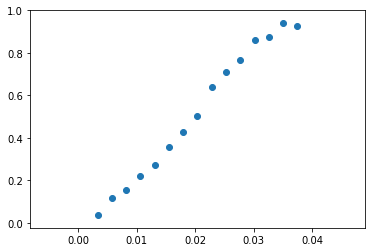

In [75]:
e_vario, lag = variogram.emp_variogram(vario, 15)
plt.scatter(e_vario[0], e_vario[1])

In [77]:
a = pd.DataFrame(np.vstack([lag, e_vario[0], e_vario[1]])).T
a.columns = ['np', 'dist', 'gamma']
print(a)

       np      dist     gamma
0   101.0  0.003284  0.036528
1   250.0  0.005725  0.114821
2   308.0  0.008167  0.152323
3   342.0  0.010609  0.217832
4   381.0  0.013051  0.270616
5   364.0  0.015493  0.355029
6   409.0  0.017935  0.429487
7   373.0  0.020377  0.504559
8   372.0  0.022819  0.641318
9   377.0  0.025261  0.710389
10  378.0  0.027703  0.767815
11  388.0  0.030145  0.859413
12  383.0  0.032587  0.872786
13  386.0  0.035029  0.939473
14  374.0  0.037471  0.928029


In [23]:
param, lag, fig = variogram.auto_vario(vario, 15, plot=False)

In [24]:
print(param)

[1.00000000e+00 1.00000000e+02 3.69193223e-02 1.03285380e+00
 2.50434823e-02]


## Step3: gls
- 共分散関数を推定
    - 観測値間の距離行列を作成
    - 推定したパラメータから$\hat{C}(0)$を推定
    - 正定値になるように処理を加える(数学的な根拠は不明, Rではどのように処理している?)
- 共分散関数の推定量を用いてgls

In [14]:
distance_mat = kriging.calc_distance_matrix(data, ['px', 'py'])

In [15]:
efrange, c0 = kriging.calc_c0(param, distance_mat)

In [78]:
print(efrange)

0.1499187183409662


In [79]:
print(c0)

0.5143686614446022


In [80]:
# 距離行列と関数形から共分散関数を求める
# reg=Trueなので正定値化処理を加えている
covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)

0.6584961564900041


In [81]:
print(covariance_mat)

[[1.17286482 0.92866573 0.95865254 ... 0.5567566  0.53849332 0.55156139]
 [0.92866573 1.17286482 1.17062241 ... 0.8103761  0.79629471 0.79341613]
 [0.95865254 1.17062241 1.17286482 ... 0.82450823 0.80967966 0.80876074]
 ...
 [0.5567566  0.8103761  0.82450823 ... 1.17286482 1.17232209 1.17209884]
 [0.53849332 0.79629471 0.80967966 ... 1.17232209 1.17286482 1.17169046]
 [0.55156139 0.79341613 0.80876074 ... 1.17209884 1.17169046 1.17286482]]


In [82]:
# 重みを用いてgls
# statsmodelsのresultクラスが返る
res, resid = kriging.do_gls(y, x, covariance_mat)

In [83]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.278
Model:                            GLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     24.02
Date:                Thu, 11 Apr 2019   Prob (F-statistic):           1.49e-09
Time:                        17:00:52   Log-Likelihood:                 2.2826
No. Observations:                 127   AIC:                           -0.5652
Df Residuals:                     125   BIC:                             5.123
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
station      -14.0001      4.654     -3.008      0.003     -23.211      -4.789
tokyo        -39.0633      6.961     -5.611      0.000     -52.841     -25.286
==============================================================================
Omnibus:                        3.540   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                2.979
Skew:                          -0.308   Prob(JB):                        0.225
Kurtosis:                       3.429   Cond. No.                         1.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Step4: kirigng
- 観測地点と予測地点の間の共分散関数$c_*$を作成する
    - 距離行列作成
    - 共分散関数にあてはめる
- 足し合わせ $\hat{Y}(s_o) = X(s_0)\hat{\beta}_{gls} + c_*'\hat{\Sigma}^{-1}(Y - X\beta)$

In [84]:
mdat = mdat_list[0]

In [85]:
mpoints = mdat[['px', 'py']].values
mexog = mdat[['station', 'tokyo']].values
points = data[['px', 'py']].values

In [86]:
mpoints = mpoints.reshape(1,2)

In [87]:
mpoints

array([[139.36231,  35.73385]])

In [88]:
# 距離行列作成
new_dist_mat = kriging.calc_distance_new_data(mpoints, points)

In [89]:
# 距離行列と関数型から共分散行列を推定
# reg=Falseを指定して正定値処理をスキップ(正方行列でないのでエラーを防ぐ)
c_mat = kriging.est_covariance_matrix(new_dist_mat, param, c0, reg=False)

In [90]:
fitted_val = kriging.put_pred_val(res, mexog)

In [91]:
kriging_val = kriging.do_kriging(fitted_val, c_mat, covariance_mat, resid)

In [92]:
kriging_val - mdat['price']

array([8305.47621097])

# CVを関数化する

In [93]:
pred_list = []
for i in range(0, 128):
    data = data_list[i]
    mdat = mdat_list[i]
    
    x = data[['station', 'tokyo']]
    y = data['price']
    step1 = sm.OLS(y, x)
    step1_res = step1.fit()
    resid = step1_res.resid
    # 前処理
    resid = pd.DataFrame(resid, columns=['residuals'])
    resid = data[['px', 'py']].join(resid)
    resid = resid.values
    
    vario = variogram.get_diff(resid)
    param, lag, fig = variogram.auto_vario(vario, 15, plot=False)
    
    distance_mat = kriging.calc_distance_matrix(data, ['px', 'py'])
    efrange, c0 = kriging.calc_c0(param, distance_mat)
    covariance_mat = kriging.est_covariance_matrix(distance_mat, param, c0)
    res, resid = kriging.do_gls(y, x, covariance_mat)
    
    mpoints = mdat[['px', 'py']].values.reshape(1, 2)
    mexog = mdat[['station', 'tokyo']].values
    points = data[['px', 'py']].values
    new_dist_mat = kriging.calc_distance_new_data(mpoints, points)
    c_mat = kriging.est_covariance_matrix(new_dist_mat, param, c0, reg=False)
    
    fitted_val = kriging.put_pred_val(res, mexog)
    kriging_val = kriging.do_kriging(fitted_val, c_mat, covariance_mat, resid)
    
    pred_list.append(kriging_val)

0.6119604678815762
0.6232557323198765
0.6317748332871018
0.6370199190453334
0.62777096139768
0.6478092341961915
0.6275746576516836
0.6342028610828943
0.646204847674859
0.6392966700539007
0.6294097076242203
0.6307432558780126
0.6435813891742648
0.6370516669512319
0.6427671730459581
0.6397266754423966
0.6390443291020094
0.6387228124416073
0.6441828652842712
0.655098607993659
0.6284629786367381
0.6565328344685569
0.6518154762325795
0.6439165712200349
0.6569816355826805
0.6545965998587966
0.6412858020399181
0.6475629695327398
0.6520094144889125
0.6450373012600167
0.6553284926589705
0.6548353452371416
0.6506025403242983
0.6486041864374941
0.655204241828633
0.6524213875189723
0.6537310125755528
0.653669426036702
0.6573749483176028
0.6514635900048726
0.6540957077957507
0.6506939859063202
0.6585173991573258
0.6497519523836514
0.6530705389732164
0.6484927579865982
0.6514386928878645
0.6532952131694588
0.6511837381319868
0.6502085127852312
0.649684989279691
0.6392798661139808
0.6579777920459842


In [94]:
obs = pd.read_csv('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/house_price_raw.csv')

In [95]:
price = np.log(obs.price)

Text(0.5, 1.0, 'Prediction of housing price(log) by hand made functions')

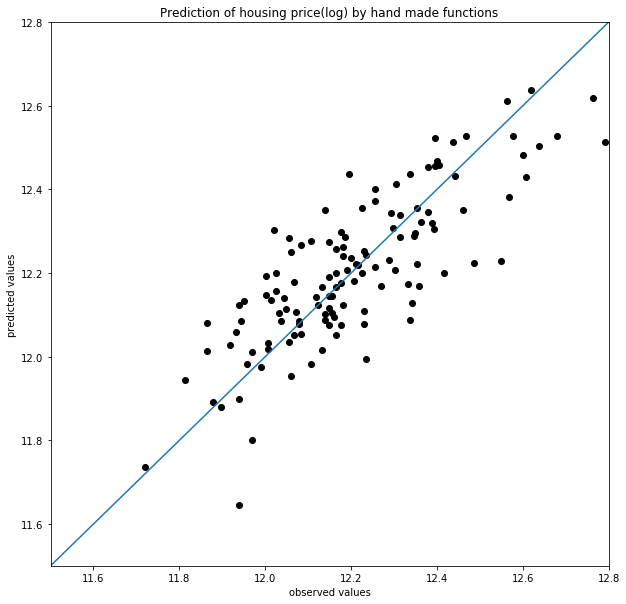

In [99]:
lim = [11.5, 12.8]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(price, pred_list, color='black')
ax.plot(np.linspace(11.5, 12.8, 100), np.linspace(11.5, 12.8, 100))
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_xlabel('observed values')
ax.set_ylabel('predicted values')
ax.set_title('Prediction of housing price(log) by hand made functions')

In [97]:
from sklearn.metrics import mean_squared_error

In [98]:
np.sqrt(mean_squared_error(price, pred_list))

0.12465217633781848

In [154]:
np.sqrt(mean_squared_error(price, pred))

0.12344811206164576

In [100]:
fig.savefig('/Users/LOng/sengokulab/LDAT_LS_2019/data/dev/plot/kriging_cv.png')